In [14]:
import os
import glob
import json
import pandas as pd


def load_reviews(folder_path):
    rows = []
    # find all JSON files in the folder
    for file_path in glob.glob(os.path.join(folder_path, '*.json')):
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        paper_id = data.get('paper_id')
        assessor = data.get('assessor')
        metrics = data.get('metrics', {})
        
        # group metrics by reviewer name
        reviewer_metrics = {}
        for key, value in metrics.items():
            # only process keys that start with "review_"
            if not key.startswith('review_'):
                continue
            parts = key.split('_')
            reviewer = parts[1]                          # e.g. "Palwinder-Singh"
            metric_name = '_'.join(parts[2:])            # e.g. "Comprehensiveness"
            
            reviewer_metrics.setdefault(reviewer, {})
            reviewer_metrics[reviewer][metric_name] = value
        
        # turn each reviewer’s metrics into a row
        for reviewer, mdict in reviewer_metrics.items():
            row = {
                'paper_id': paper_id,
                'assessor': assessor,
                'reviewer': reviewer
            }
            row.update(mdict)
            rows.append(row)
    
    # build the final DataFrame
    df = pd.DataFrame(rows)
    return df

# Example usage:
folder = 'Human_Annotation_Data'
df_human = load_reviews(folder)

# show the first few rows
df_human = df_human[df_human['Overall_Quality'] > 10]
df_human

,paper_id,assessor,reviewer,Comprehensiveness,Usage_of_Technical_Terms,Factuality,Sentiment_Polarity,Politeness,Vagueness,Objectivity,Fairness,Actionability,Constructiveness,Relevance_Alignment,Clarity_and_Readability,Overall_Quality
0,166,Sajad-Ebrahimi,Reviewer-7mFW,2,4,factual,neutral,polite,high,4,4,4,3,4,4,67
1,166,Sajad-Ebrahimi,Reviewer-FAWm,4,4,factual,neutral,polite,none,4,4,5,5,5,4,86
2,166,Sajad-Ebrahimi,Reviewer-kjkr,3,4,factual,neutral,polite,low,4,4,5,5,4,5,75
3,100,Seyed,Enrico-Daga,3,2,factual,positive,polite,none,4,5,4,4,4,4,80
4,100,Seyed,Julia-Bosque,5,4,factual,positive,polite,low,4,4,4,4,5,4,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,75,Ali-Ghorbanpour,Reviewer-s437,3,3,partially factual,neutral,polite,low,2,3,2,3,3,3,55
523,75,Ali-Ghorbanpour,Reviewer-mMGf,4,4,factual,negative,polite,none,4,4,4,5,4,4,80
524,75,Ali-Ghorbanpour,Reviewer-AtQ2,5,4,factual,positive,polite,none,4,4,3,4,4,5,90
525,75,Ali-Ghorbanpour,Reviewer-v6cq,2,3,partially factual,positive,polite,moderate,3,3,2,3,3,3,50


In [15]:
# count rows with Anonymous reviewer
df_human['reviewer'].value_counts().loc['Anonymous']
# drop rows with Anonymous reviewer
df_human = df_human[df_human['reviewer'] != 'Anonymous']
# count rows with Anonymous reviewer

In [17]:
df_llama = pd.read_json('final_data/HA_ALL_llama.json', orient='records', lines=True)
df_qwen = pd.read_json('final_data/HA_ALL_qwen.json')
df_gpt = pd.read_csv('final_data/HA_ALL_gpt.csv')
df_phi = pd.read_csv('final_data/HA_ALL_phi4.csv')

In [18]:
df_qmetric = pd.read_json('final_data/HA_ALL_nonllm.json', orient='records', lines=True)

columns_to_drop = [
    'title', 'abstract', 'review_text', 'authors', 'review_date', 
    'review_rating', 'review_confidence', 'review_soundness', 
    'review_presentation', 'review_contribution', 'days_to_submit', 
    'flesch_kincaid_grade', 'gunning_fog', 'smog_index', 
    'automated_readability_index', 'llm_length_effort', 
    'llm_lexical_diversity', 'llm_questions_raised', 'llm_citation_usage', 
    'llm_sentiment_polarity', 'llm_politeness', 'llm_hedging', 
    'llm_specificity', 'llm_domain_terms', 'llm_relevance_alignment', 
    'llm_readability', 'llm_overall_quality', 'llm_overall_score_100', 'venue', 'review_suggestion'
]
df_qmetric = df_qmetric.drop(columns=columns_to_drop)

# Rename columns in df_qmetric
df_qmetric = df_qmetric.rename(columns={
    'length_words': 'llm_Comprehensiveness',
    'citation_count': 'llm_Factuality',
    'mattr': 'llm_Usage of Technical Terms',
    'sentiment_polarity': 'llm_Sentiment Polarity',
    'similarity_score': 'llm_Relevance Alignment',
    'flesch_reading_ease': 'llm_Clarity and Readability',
    'politeness_score': 'llm_Politeness',
    'question_count': 'llm_Actionability'
})

# Calculate llm_Vagueness using the hedge columns
df_qmetric['llm_Vagueness'] = 1 - (df_qmetric['hedge_C'] / (df_qmetric['hedge_C'] + df_qmetric['hedge_D'] + df_qmetric['hedge_E'] + df_qmetric['hedge_I'] + df_qmetric['hedge_N']))

# Drop all columns that start with 'hedge_'
df_qmetric = df_qmetric.drop(columns=[col for col in df_qmetric.columns if col.startswith('hedge_')])

# Add new columns with null values
df_qmetric['llm_Objectivity'] = None
df_qmetric['llm_Overall_Quality'] = None
df_qmetric['llm_Fairness'] = None
df_qmetric['llm_Constructiveness'] = None


# for col in df_qmetric.columns:
#     print(f"{col}: {df_qmetric[col].dtype}")

In [19]:
# remove 'llm_' from all columns prefix in df_llama and df_qwen
df_human.columns = df_human.columns.str.replace(' ', '_', regex=False)
df_llama.columns = df_llama.columns.str.replace(' ', '_', regex=False)
df_qwen.columns = df_qwen.columns.str.replace(' ', '_', regex=False)
df_gpt.columns = df_gpt.columns.str.replace(' ', '_', regex=False)
df_qmetric.columns = df_qmetric.columns.str.replace(' ', '_', regex=False)
df_phi.columns = df_phi.columns.str.replace(' ', '_', regex=False)


df_human.columns = df_human.columns.str.replace('llm_', '', regex=False)
df_llama.columns = df_llama.columns.str.replace('llm_', '', regex=False)
df_qwen.columns = df_qwen.columns.str.replace('llm_', '', regex=False)
df_gpt.columns = df_gpt.columns.str.replace('llm_', '', regex=False)
df_qmetric.columns = df_qmetric.columns.str.replace('llm_', '', regex=False)
df_phi.columns = df_phi.columns.str.replace('llm_', '', regex=False)

In [20]:
# print shared columns between df_llama and df
shared_columns_llama = set(df_llama.columns) & set(df_human.columns)
print("Shared columns between df_llama and df:")
print(shared_columns_llama)
# print shared columns between df_qwen and df
shared_columns_qwen = set(df_qwen.columns) & set(df_human.columns)
print("Shared columns between df_qwen and df:")
print(shared_columns_qwen)
# print shared columns between df_gpt and df
shared_columns_gpt = set(df_gpt.columns) & set(df_human.columns)
print("Shared columns between df_gpt and df:")
print(shared_columns_gpt)
# print shared columns between df_qmetrics and df
shared_columns_qmetric = set(df_qmetric.columns) & set(df_human.columns)
print("Shared columns between df_qmetrics and df:")
print(shared_columns_qmetric)
# print shared columns between df_phi and df
shared_columns_phi = set(df_phi.columns) & set(df_human.columns)
print("Shared columns between df_phi and df:")
print(shared_columns_phi)

Shared columns between df_llama and df:
{'Relevance_Alignment', 'Overall_Quality', 'Objectivity', 'Factuality', 'Clarity_and_Readability', 'paper_id', 'reviewer', 'Comprehensiveness', 'Constructiveness', 'Politeness', 'Fairness', 'Sentiment_Polarity', 'Vagueness', 'Actionability', 'Usage_of_Technical_Terms'}
Shared columns between df_qwen and df:
{'Relevance_Alignment', 'Overall_Quality', 'Objectivity', 'Factuality', 'Clarity_and_Readability', 'paper_id', 'reviewer', 'Comprehensiveness', 'Constructiveness', 'Politeness', 'Fairness', 'Sentiment_Polarity', 'Vagueness', 'Actionability', 'Usage_of_Technical_Terms'}
Shared columns between df_gpt and df:
{'Relevance_Alignment', 'Overall_Quality', 'Objectivity', 'Factuality', 'Clarity_and_Readability', 'paper_id', 'reviewer', 'Comprehensiveness', 'Constructiveness', 'Politeness', 'Fairness', 'Sentiment_Polarity', 'Vagueness', 'Actionability', 'Usage_of_Technical_Terms'}
Shared columns between df_qmetrics and df:
{'Relevance_Alignment', 'Overa

In [21]:
# Convert paper_id and reviewer to string in all DataFrames
for dframe in [df_human, df_qwen, df_llama, df_qmetric, df_gpt, df_phi]:
    dframe['paper_id'] = dframe['paper_id'].astype(str)
    dframe['reviewer'] = dframe['reviewer'].astype(str)

# Define shared metrics (excluding paper_id and reviewer)
shared_metrics = [
    'Comprehensiveness', 'Usage_of_Technical_Terms', 'Relevance_Alignment',
    'Objectivity', 'Sentiment_Polarity', 'Vagueness', 'Factuality',
    'Fairness', 'Actionability', 'Overall_Quality', 'Constructiveness',
    'Clarity_and_Readability', 'Politeness'
]

# Rename columns with prefixes
df_human_renamed = df_human.rename(columns={col: f'Human_{col}' for col in shared_metrics})
df_qwen_renamed = df_qwen.rename(columns={col: f'Qwen_{col}' for col in shared_metrics})
df_llama_renamed = df_llama.rename(columns={col: f'Llama_{col}' for col in shared_metrics})
df_gpt_renamed = df_gpt.rename(columns={col: f'GPT_{col}' for col in shared_metrics})
df_qmetric_renamed = df_qmetric.rename(columns={col: f'Qmetric_{col}' for col in shared_metrics})
df_phi_renamed = df_phi.rename(columns={col: f'Phi_{col}' for col in shared_metrics})

# just for column reviewer, replace '_' and ' ' with '-'
df_llama_renamed['reviewer'] = df_llama_renamed['reviewer'].str.replace('_', '-', regex=False)
df_llama_renamed['reviewer'] = df_llama_renamed['reviewer'].str.replace(' ', '-', regex=False)
df_qwen_renamed['reviewer'] = df_qwen_renamed['reviewer'].str.replace('_', '-', regex=False)
df_qwen_renamed['reviewer'] = df_qwen_renamed['reviewer'].str.replace(' ', '-', regex=False)
df_human_renamed['reviewer'] = df_human_renamed['reviewer'].str.replace('_', '-', regex=False)
df_human_renamed['reviewer'] = df_human_renamed['reviewer'].str.replace(' ', '-', regex=False)
df_gpt_renamed['reviewer'] = df_gpt_renamed['reviewer'].str.replace('_', '-', regex=False)
df_gpt_renamed['reviewer'] = df_gpt_renamed['reviewer'].str.replace(' ', '-', regex=False)
df_qmetric_renamed['reviewer'] = df_qmetric_renamed['reviewer'].str.replace('_', '-', regex=False)
df_qmetric_renamed['reviewer'] = df_qmetric_renamed['reviewer'].str.replace(' ', '-', regex=False)
df_phi_renamed['reviewer'] = df_phi_renamed['reviewer'].str.replace('_', '-', regex=False)
df_phi_renamed['reviewer'] = df_phi_renamed['reviewer'].str.replace(' ', '-', regex=False)

# transform paper_id column in all dfs to int
df_human_renamed['paper_id'] = df_human_renamed['paper_id'].astype(int)
df_qwen_renamed['paper_id'] = df_qwen_renamed['paper_id'].astype(int)
df_llama_renamed['paper_id'] = df_llama_renamed['paper_id'].astype(int)
df_gpt_renamed['paper_id'] = df_gpt_renamed['paper_id'].astype(int)
df_qmetric_renamed['paper_id'] = df_qmetric_renamed['paper_id'].astype(int)
df_phi_renamed['paper_id'] = df_phi_renamed['paper_id'].astype(int)

# transform paper_id column in all dfs to int
df_human_renamed['reviewer'] = df_human_renamed['reviewer'].astype(str)
df_qwen_renamed['reviewer'] = df_qwen_renamed['reviewer'].astype(str)
df_llama_renamed['reviewer'] = df_llama_renamed['reviewer'].astype(str)
df_gpt_renamed['reviewer'] = df_gpt_renamed['reviewer'].astype(str)
df_qmetric_renamed['reviewer'] = df_qmetric_renamed['reviewer'].astype(str)
df_phi_renamed['reviewer'] = df_phi_renamed['reviewer'].astype(str)


# Perform sequential INNER joins to retain only rows present in all DataFrames
df_human_vs_llm = (
    df_human_renamed
    .merge(df_llama_renamed, on=['paper_id', 'reviewer'], how='inner')
    .merge(df_qwen_renamed, on=['paper_id', 'reviewer'], how='inner')
    .merge(df_gpt_renamed, on=['paper_id', 'reviewer'], how='inner')
    .merge(df_phi_renamed, on=['paper_id', 'reviewer'], how='inner')
    # .merge(df_qmetric_renamed, on=['paper_id', 'reviewer'], how='inner')
)


# Create ordered column list (Human first, then Qwen, then Llama)
column_order = (
    ['paper_id', 'reviewer'] + 
    sorted([col for col in df_human_vs_llm if col.startswith('Human_')]) +
    sorted([col for col in df_human_vs_llm if col.startswith('Qwen_')]) +
    sorted([col for col in df_human_vs_llm if col.startswith('Llama_')]) +
    sorted([col for col in df_human_vs_llm if col.startswith('GPT_')]) +
    sorted([col for col in df_human_vs_llm if col.startswith('Phi_')])
    # + sorted([col for col in df_human_vs_llm if col.startswith('Qmetric_')])
)

df_human_vs_llm = df_human_vs_llm[column_order]
df_human_vs_llm

/tmp/ipykernel_3569827/3720116104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe['paper_id'] = dframe['paper_id'].astype(str)
/tmp/ipykernel_3569827/3720116104.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dframe['reviewer'] = dframe['reviewer'].astype(str)


,paper_id,reviewer,Human_Actionability,Human_Clarity_and_Readability,Human_Comprehensiveness,Human_Constructiveness,Human_Factuality,Human_Fairness,Human_Objectivity,Human_Overall_Quality,...,Phi_Constructiveness,Phi_Factuality,Phi_Fairness,Phi_Objectivity,Phi_Overall_Quality,Phi_Politeness,Phi_Relevance_Alignment,Phi_Sentiment_Polarity,Phi_Usage_of_Technical_Terms,Phi_Vagueness
0,166,Reviewer-7mFW,4,4,2,3,factual,4,4,67,...,4,partially factual,3,4,75,polite,5,neutral,4,low
1,166,Reviewer-FAWm,5,4,4,5,factual,4,4,86,...,4,partially factual,4,4,85,polite,5,neutral,3,low
2,166,Reviewer-kjkr,5,5,3,5,factual,4,4,75,...,4,partially factual,4,3,78,neutral,5,negative,5,low
3,100,Enrico-Daga,4,4,3,4,factual,5,4,80,...,4,factual,4,4,85,polite,5,positive,3,low
4,100,Julia-Bosque,4,4,5,4,factual,4,4,87,...,5,factual,5,5,95,polite,5,positive,4,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,75,Reviewer-s437,2,3,3,3,partially factual,3,2,55,...,4,factual,4,4,85,polite,5,neutral,5,low
446,75,Reviewer-mMGf,4,4,4,5,factual,4,4,80,...,4,partially factual,4,4,85,polite,5,neutral,3,low
447,75,Reviewer-AtQ2,3,5,5,4,factual,4,4,90,...,4,partially factual,4,4,85,polite,5,neutral,5,low
448,75,Reviewer-v6cq,2,3,2,3,partially factual,3,3,50,...,3,partially factual,4,3,75,polite,4,positive,4,low


In [22]:
df_human_vs_llm.columns

Index(['paper_id', 'reviewer', 'Human_Actionability',
       'Human_Clarity_and_Readability', 'Human_Comprehensiveness',
       'Human_Constructiveness', 'Human_Factuality', 'Human_Fairness',
       'Human_Objectivity', 'Human_Overall_Quality', 'Human_Politeness',
       'Human_Relevance_Alignment', 'Human_Sentiment_Polarity',
       'Human_Usage_of_Technical_Terms', 'Human_Vagueness',
       'Qwen_Actionability', 'Qwen_Clarity_and_Readability',
       'Qwen_Comprehensiveness', 'Qwen_Constructiveness', 'Qwen_Factuality',
       'Qwen_Fairness', 'Qwen_Objectivity', 'Qwen_Overall_Quality',
       'Qwen_Politeness', 'Qwen_Relevance_Alignment',
       'Qwen_Sentiment_Polarity', 'Qwen_Usage_of_Technical_Terms',
       'Qwen_Vagueness', 'Llama_Actionability',
       'Llama_Clarity_and_Readability', 'Llama_Comprehensiveness',
       'Llama_Constructiveness', 'Llama_Factuality', 'Llama_Fairness',
       'Llama_Objectivity', 'Llama_Overall_Quality', 'Llama_Politeness',
       'Llama_Relevance_A

In [23]:
# drop rows with NaN values in any of the shared metrics
df_human_vs_llm = df_human_vs_llm.dropna()
df_human_vs_llm.shape

(434, 67)

In [24]:
df_human_vs_llm.to_csv('Qmetrics-vs-Human/human_vs_llm.csv', index=False)

In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
import krippendorff
from scipy.stats import pearsonr, kendalltau

# Assuming your DataFrame is named 'df'
df = df_human_vs_llm.copy()


CATEGORY_MAP = {
    'Factuality': ['factual', 'partially factual', 'unfactual'],
    'Politeness': ['polite', 'neutral', 'impolite'],
    'Sentiment_Polarity': ['negative', 'neutral', 'positive'],
    'Vagueness': ['none', 'low', 'moderate', 'high', 'extreme']
}

results = []

# Process categorical features
for feature in CATEGORY_MAP:
    human_col = f"Human_{feature}"
    for llm in ['Qwen', 'Llama', 'GPT', 'Phi']:
        llm_col = f"{llm}_{feature}"
        if human_col not in df.columns or llm_col not in df.columns:
            continue  # Skip if columns are missing
        
        temp_df = df[[human_col, llm_col]].copy()
        valid_labels = CATEGORY_MAP[feature]
        
        # Filter rows with valid labels
        mask = temp_df[human_col].isin(valid_labels) & temp_df[llm_col].isin(valid_labels)
        temp_df = temp_df[mask].reset_index(drop=True)
        
        if len(temp_df) < 2:
            continue  # Not enough data
        
        # Map labels to integers
        label_to_int = {label: idx for idx, label in enumerate(valid_labels)}
        temp_df[human_col] = temp_df[human_col].map(label_to_int)
        temp_df[llm_col] = temp_df[llm_col].map(label_to_int)
        
        # Compute metrics
        try:
            kappa = cohen_kappa_score(temp_df[human_col], temp_df[llm_col])
        except:
            kappa = np.nan
        
        data = [temp_df[human_col].values, temp_df[llm_col].values]
        try:
            alpha = krippendorff.alpha(data, level_of_measurement='ordinal')
        except:
            alpha = np.nan
        
        try:
            pearson_corr, _ = pearsonr(temp_df[human_col], temp_df[llm_col])
        except:
            pearson_corr = np.nan
        
        try:
            kendall_corr, _ = kendalltau(temp_df[human_col], temp_df[llm_col])
        except:
            kendall_corr = np.nan
        
        results.append({
            'Human_Column': human_col,
            'LLM_Column': llm_col,
            'Kendall_Tau': kendall_corr,
            'Krippendorff_Alpha': alpha,
            'Cohen_Kappa': kappa,
            'Pearson': pearson_corr
        })

# Process non-categorical features
all_features = set(col.split('_', 1)[1] for col in df.columns if col.startswith('Human_'))
non_categorical_features = [f for f in all_features if f not in CATEGORY_MAP]

for feature in non_categorical_features:
    human_col = f"Human_{feature}"
    for llm in ['Qwen', 'Llama', 'GPT', 'Phi']:
        llm_col = f"{llm}_{feature}"
        if human_col not in df.columns or llm_col not in df.columns:
            continue  # Skip if columns are missing
        
        temp_df = df[[human_col, llm_col]].dropna().copy()
        if len(temp_df) < 2:
            continue  # Not enough data
        
        # Ensure integer type
        try:
            temp_df[human_col] = temp_df[human_col].astype(int)
            temp_df[llm_col] = temp_df[llm_col].astype(int)
        except:
            continue  # Skip if conversion fails
        
        # Compute metrics
        try:
            kappa = cohen_kappa_score(temp_df[human_col], temp_df[llm_col])
        except:
            kappa = np.nan
        
        data = [temp_df[human_col].values, temp_df[llm_col].values]
        try:
            alpha = krippendorff.alpha(data, level_of_measurement='ordinal')
        except:
            alpha = np.nan
        
        try:
            pearson_corr, _ = pearsonr(temp_df[human_col], temp_df[llm_col])
        except:
            pearson_corr = np.nan
        
        try:
            kendall_corr, _ = kendalltau(temp_df[human_col], temp_df[llm_col])
        except:
            kendall_corr = np.nan
        
        results.append({
            'Human_Column': human_col,
            'LLM_Column': llm_col,
            'Kendall_Tau': kendall_corr,
            'Krippendorff_Alpha': alpha,
            'Cohen_Kappa': kappa,
            'Pearson': pearson_corr
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

,Human_Column,LLM_Column,Kendall_Tau,Krippendorff_Alpha,Cohen_Kappa,Pearson
0,Human_Factuality,Qwen_Factuality,0.089154,0.090601,0.090651,0.084903
1,Human_Factuality,Llama_Factuality,-0.056688,-0.080783,-0.037566,-0.051113
2,Human_Factuality,GPT_Factuality,0.115470,-0.021322,0.063905,0.116758
3,Human_Factuality,Phi_Factuality,0.005891,-0.053949,0.026396,-0.008699
4,Human_Politeness,Qwen_Politeness,0.106031,0.010201,0.049352,0.135548
5,Human_Politeness,Llama_Politeness,0.024499,-0.131752,0.011853,0.009248
6,Human_Politeness,GPT_Politeness,0.127962,0.078503,0.078544,0.154120
7,Human_Politeness,Phi_Politeness,0.052525,-0.034709,0.028085,0.063275
8,Human_Sentiment_Polarity,Qwen_Sentiment_Polarity,0.428128,0.442793,0.307873,0.459360
9,Human_Sentiment_Polarity,Llama_Sentiment_Polarity,0.378163,0.326058,0.160261,0.414148


In [26]:
results_df.to_csv('final_data/human_vs_llm_agreement_corr.csv', index=False)

In [24]:
df = pd.read_csv('final_data/human_vs_llm_agreement_corr.csv')
df

,Human_Column,LLM_Column,Kendall_Tau,Krippendorff_Alpha,Cohen_Kappa,Pearson
0,Human_Factuality,Qwen_Factuality,0.089154,0.090601,0.090651,0.084903
1,Human_Factuality,Llama_Factuality,-0.056688,-0.080783,-0.037566,-0.051113
2,Human_Factuality,GPT_Factuality,0.115470,-0.021322,0.063905,0.116758
3,Human_Factuality,Phi_Factuality,0.005891,-0.053949,0.026396,-0.008699
4,Human_Politeness,Qwen_Politeness,0.106031,0.010201,0.049352,0.135548
5,Human_Politeness,Llama_Politeness,0.024499,-0.131752,0.011853,0.009248
6,Human_Politeness,GPT_Politeness,0.127962,0.078503,0.078544,0.154120
7,Human_Politeness,Phi_Politeness,0.052525,-0.034709,0.028085,0.063275
8,Human_Sentiment_Polarity,Qwen_Sentiment_Polarity,0.428128,0.442793,0.307873,0.459360
9,Human_Sentiment_Polarity,Llama_Sentiment_Polarity,0.378163,0.326058,0.160261,0.414148


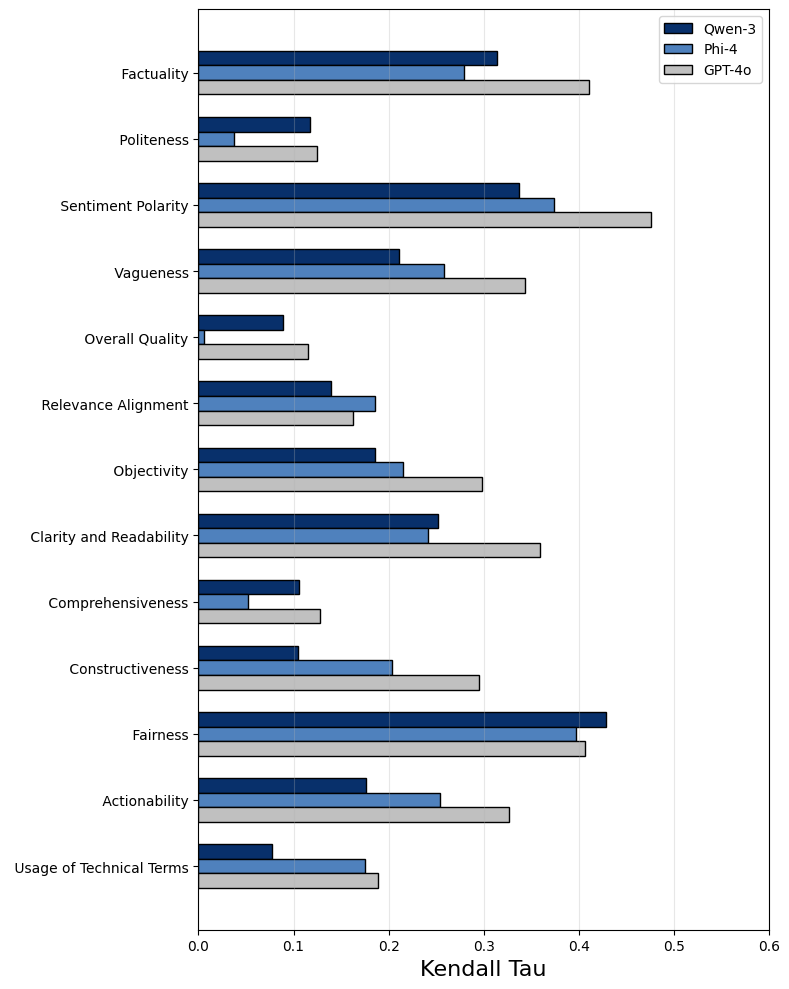

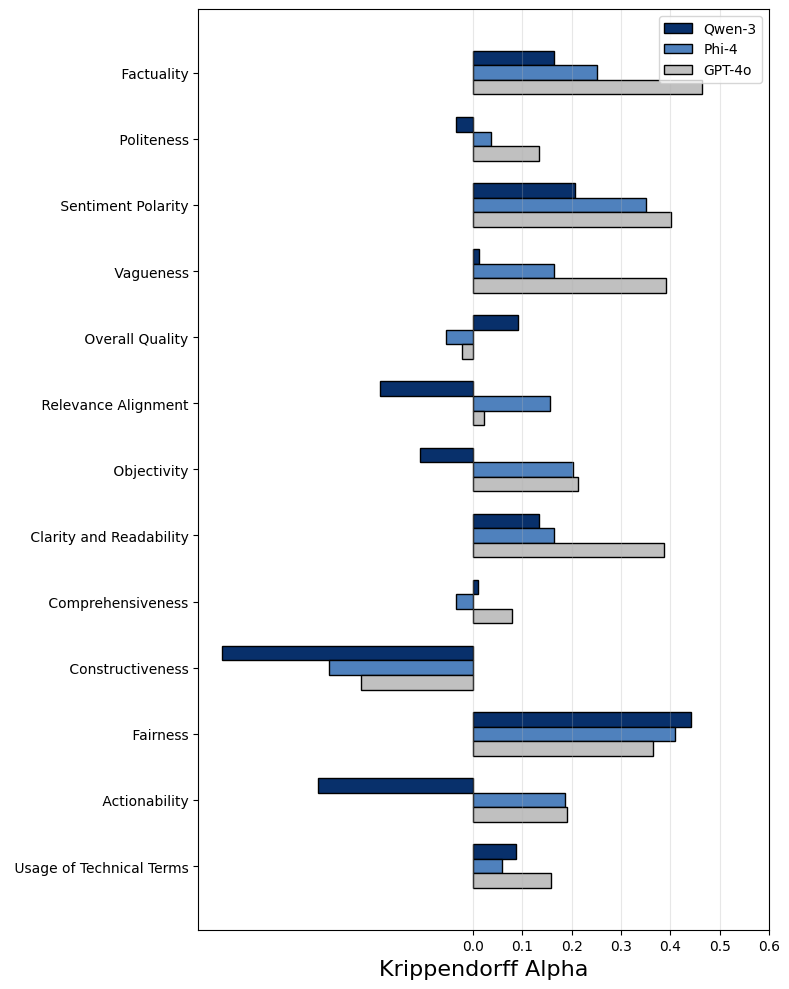

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5  # default is 1.0

# Load data and preprocess
df = pd.read_csv('final_data/human_vs_llm_agreement_corr.csv')

# Extract LLM names from LLM_Column
df['LLM'] = df['LLM_Column'].str.split('_').str[0]

# Get unique features and LLMs
features = df['Human_Column'].str.replace('_', ' ').str.replace('Human', '').unique()

llms = ['Qwen', 'Phi', 'GPT'] # 'Llama', 

colors = {
    'Qwen': '#08306B',    # Very Dark Blue (Navy)
    'Phi': '#4F81BD',   # Medium Blue
    'GPT':  '#C0C0C0'    # Medium Light Gray
}

# Create separate figures for each metric
for metric in ['Kendall_Tau', 'Krippendorff_Alpha']:
    plt.figure(figsize=(8, 10))  # Adjusted for better vertical spacing
    
    # Set positions and dimensions
    n_features = len(features)
    bar_height = 0.33
    y = np.arange(n_features) * 1.5  # Vertical spacing between metric groups
    
    # Plot horizontal bars
    for i, llm in enumerate(llms):
        sorted_df = df[df['LLM'] == llm].sort_values('Human_Column')
        values = sorted_df[metric].values
        tmp_label = ''
        if llm == 'Qwen':
            tmp_label = 'Qwen-3'
        elif llm == 'GPT':
            tmp_label = 'GPT-4o'
        elif llm == 'Llama':
            tmp_label = 'LLaMA-3'
        elif llm == 'Phi':
            tmp_label = 'Phi-4'
        plt.barh(y + i*bar_height, 
                values, 
                height=bar_height,
                edgecolor='black',
                linewidth=1,
                color=colors[llm],
                label=tmp_label)
    
    # Format axes and labels
    plt.title(f'', fontsize=16)
    plt.xlabel(f'{metric.replace("_", " ")}', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(y + bar_height, features, rotation=0, ha='right')
    plt.xticks(np.arange(0, 0.65, 0.1))
    plt.gca().invert_yaxis()  # Top metric appears first
    plt.grid(axis='x', alpha=0.3)
    
    # Add legend and adjust layout
    plt.legend(loc='upper right', frameon=True)
    plt.tight_layout()
    plt.show()

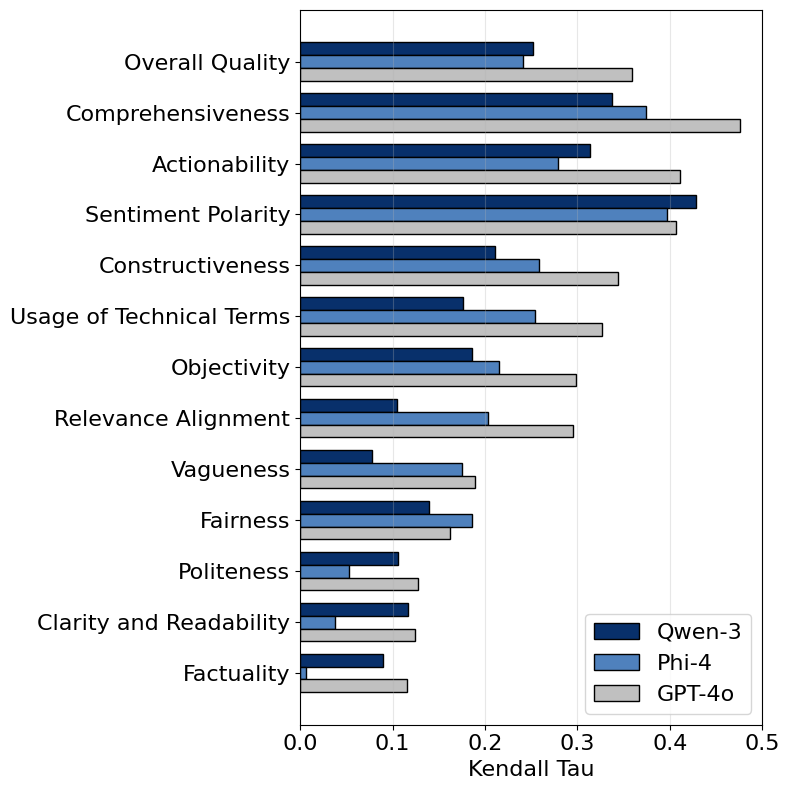

In [56]:
import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams.update({
    'axes.labelsize': 16,    # X/Y axis labels
    'xtick.labelsize': 16,   # X-axis ticks
    'ytick.labelsize': 16,   # Y-axis ticks
    'legend.fontsize': 16,   # Legend
    'axes.titlesize': 16     # Title
})


# Prepare the data in DataFrame format
data = {
    'Feature': [
        'Factuality', 'Politeness', 'Sentiment Polarity', 'Vagueness',
        'Overall Quality', 'Relevance Alignment', 'Objectivity',
        'Clarity and Readability', 'Comprehensiveness', 'Constructiveness',
        'Fairness', 'Actionability', 'Usage of Technical Terms'
    ] * 3,
    'Model': ['GPT']*13 + ['Phi']*13 + ['Qwen']*13,
    'Kendall_Tau': [
        # GPT values
        0.1154702106, 0.1279620828, 0.4068176159, 0.1892757009, 0.3593823442,
        0.2950698280, 0.2980277983, 0.1243677194, 0.4757011695, 0.3434981603,
        0.1626953658, 0.4110018987, 0.3265318659,
        # Phi values
        0.0058909791, 0.0525245185, 0.3968250646, 0.1750917187, 0.2409868802,
        0.2036074339, 0.2149245806, 0.0377247100, 0.3744011304, 0.2586821165,
        0.1856319603, 0.2787881922, 0.2540390588,
        # Qwen values
        0.0891536363, 0.1060308786, 0.4281282488, 0.0776353591, 0.2516097828,
        0.1047622454, 0.1861675026, 0.1170706192, 0.3376016235, 0.2111818772,
        0.1392957972, 0.3140315632, 0.1759634292
    ]
}

df = pd.DataFrame(data)

# Create sorting key - GPT values for each feature
sorted_features = (df[df['Model'] == 'GPT']
                   .sort_values('Kendall_Tau', ascending=False)['Feature']
                   .tolist())

# Remove 'Overall Quality' from sorted list and append it at the end
sorted_features = ['Overall Quality'] + [f for f in sorted_features if f != 'Overall Quality']

# Create a categorical type for sorting
df['Feature'] = pd.Categorical(df['Feature'], categories=sorted_features[::-1], ordered=True)
df = df.sort_values('Feature', ascending=False)

# Plot configuration
colors = {'Qwen': '#08306B', 'Phi': '#4F81BD', 'GPT': '#C0C0C0'}
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Plot each model's bars with offset
for i, model in enumerate(['Qwen', 'Phi', 'GPT']):
    subset = df[df['Model'] == model]
    positions = [y + i*0.25 for y in range(len(subset))]
    tmp_label = ''
    if model == 'Qwen':
        tmp_label = 'Qwen-3'
    elif model == 'GPT':
        tmp_label = 'GPT-4o'
    elif model == 'Llama':
        tmp_label = 'LLaMA-3'
    elif model == 'Phi':
        tmp_label = 'Phi-4'
    ax.barh(positions, subset['Kendall_Tau'], 
            height=0.25, color=colors[model], label=tmp_label, edgecolor='black', linewidth=1)

# Set y-axis labels and positions
ax.set_yticks([y + 0.25 for y in range(len(sorted_features))])
ax.set_yticklabels(sorted_features)
ax.invert_yaxis()  # To have highest values at top

# Add labels and legend
plt.xlabel('Kendall Tau')
plt.title('')
plt.legend(loc='lower right')

# Adjust margins and layout
plt.xlim(0.0, 0.5)
plt.subplots_adjust(left=0.3)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('Figs/kendall_tau_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()